In [1]:
cd .. 

c:\Users\Usuario\OneDrive\Documents\IE\3. Trimestre\Venture Lab & Capstone\Capstone\Tech side\vl_optimizer


Import required libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

Import the data & perform the forecast using an ARIMA(5,1,0)

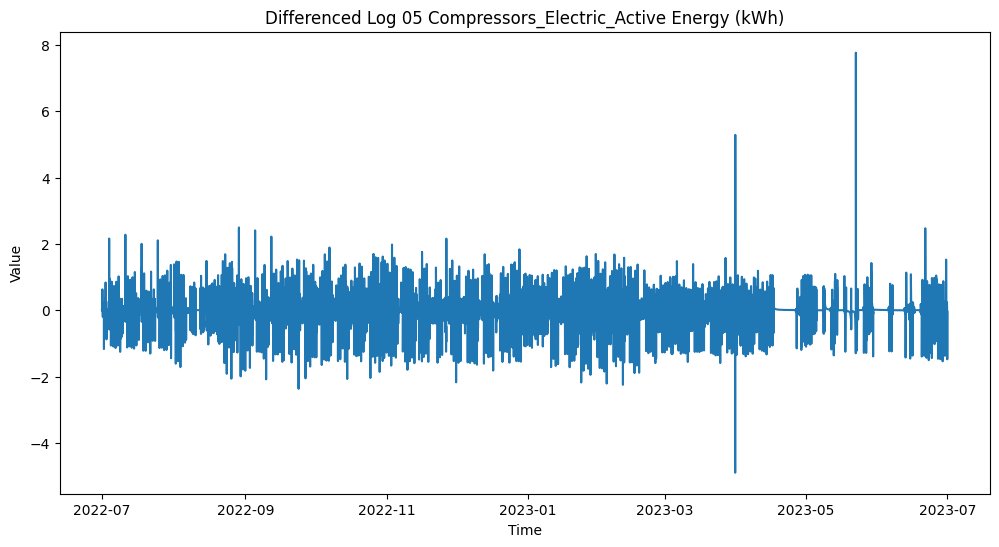

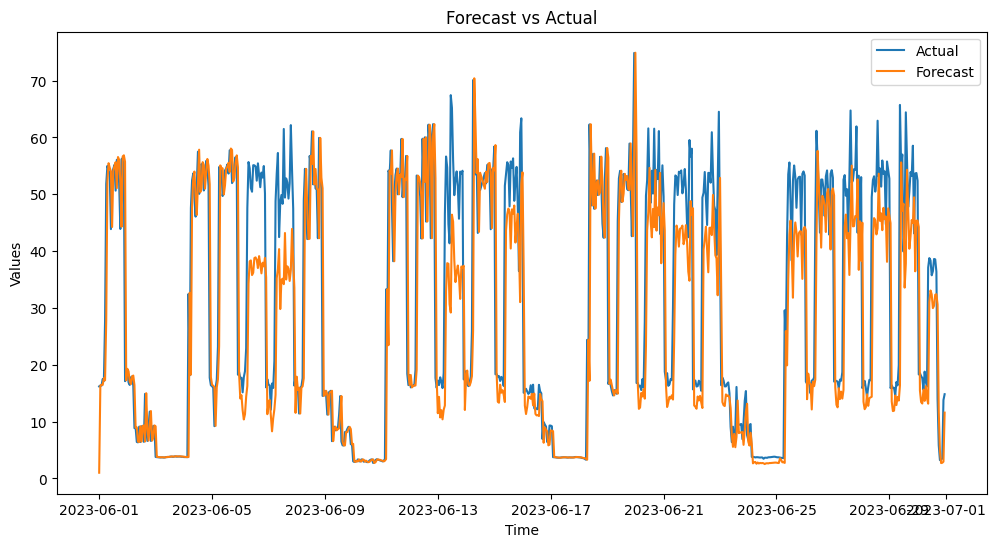

RMSE: 11.059157691309673


In [3]:
# Load the data
data = pd.read_csv('data/processed_data/industrial_sites_processed/2024-07-09T19-25-47_industrial_site2_processed.csv')

data = data.dropna()

# Convert 'Time' column to datetime
data['Time'] = pd.to_datetime(data['Time'])

# Set 'Time' column as the index
data.set_index('Time', inplace=True)

# Extract the target column for forecasting
target_column = '05 Compressors_Electric_Active Energy (kWh)'

# Apply log transformation
data['Log_' + target_column] = np.log(data[target_column])

# Apply differencing
data['Diff_Log_' + target_column] = data['Log_' + target_column].diff().dropna()

# Plot the target column to visualize its trend
plt.figure(figsize=(12, 6))
plt.plot(data['Diff_Log_' + target_column])
plt.title('Differenced Log ' + target_column)
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Define the start of the testing period
test_start_date = '2023-06-01'

# Split the data into training and testing sets
train = data['Diff_Log_' + target_column].loc[:test_start_date].dropna()
test = data['Diff_Log_' + target_column].loc[test_start_date:].dropna()

# Initialize lists to store results
results = []

# Fit ARIMA model and forecast in a rolling manner
for i in range(0, len(test), 24):
    # Fit ARIMA model
    model = ARIMA(train, order=(5, 1, 0))
    model_fit = model.fit()

    # Forecast the next 24 hours
    forecast_steps = 24
    if len(test) - i < forecast_steps:
        forecast_steps = len(test) - i
    forecast = model_fit.forecast(steps=forecast_steps)
    
    # Append results to the list
    for j in range(forecast_steps):
        forecast_value = forecast.iloc[j]
        if i + j > 0:
            # Inverse differencing
            forecast_value = forecast_value + data['Log_' + target_column].iloc[i + j - 1]
            # Inverse log transformation
            forecast_value = np.exp(forecast_value)
        else:
            # Inverse log transformation for the first value
            forecast_value = np.exp(forecast_value)
        
        results.append({
            'Time': test.index[i + j],
            'Real Values': np.exp(data['Log_' + target_column].iloc[i + j]),
            'Forecasting Values': forecast_value
        })
    
    # Update training set with real data
    train = pd.concat([train, test[i:i + forecast_steps]])

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Save results to a CSV file
results_df.to_csv('data/forecasted_data/compressor_consumption_forecast_results.csv', index=False)

# Save the model
joblib.dump(model_fit, 'forecasting/forecasters/compressor_consumption_forecaster.pkl')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(results_df['Time'], results_df['Real Values'], label='Actual')
plt.plot(results_df['Time'], results_df['Forecasting Values'], label='Forecast')
plt.title('Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

# Calculate forecast accuracy for the entire period
mse = mean_squared_error(results_df['Real Values'], results_df['Forecasting Values'])
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

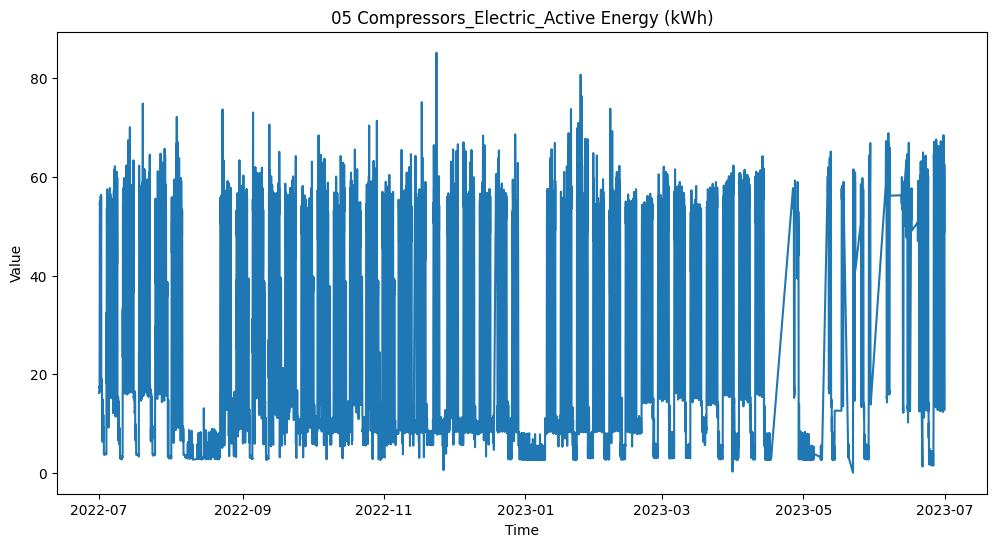

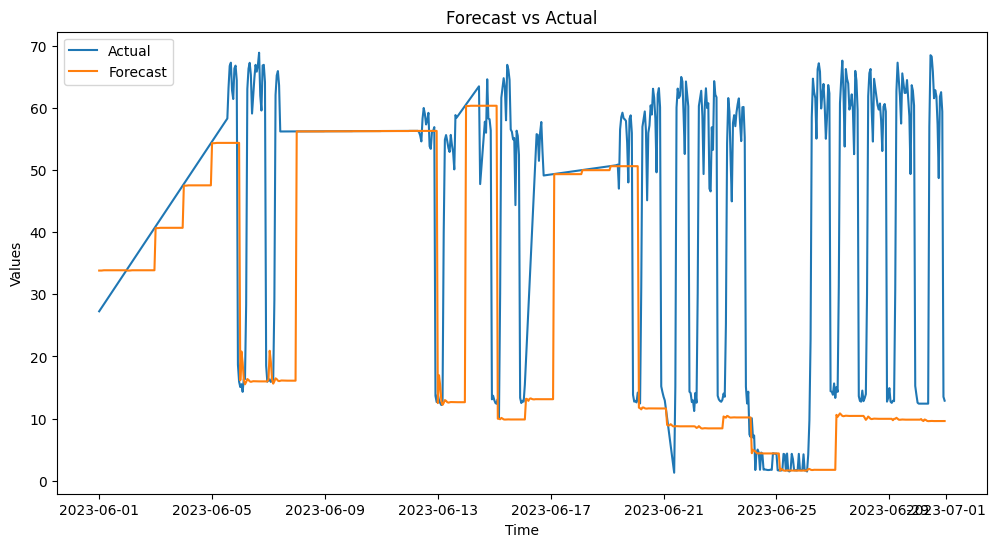

RMSE: 28.026564218795897


In [4]:


# Load the data
data = pd.read_csv('data/processed_data/industrial_sites_processed/2024-07-07T16-56-34_industrial_site2_processed.csv')

data=data.dropna()

# Convert 'Time' column to datetime
data['Time'] = pd.to_datetime(data['Time'])

# Set 'Time' column as the index
data.set_index('Time', inplace=True)

# Extract the target column for forecasting
target_column = '05 Compressors_Electric_Active Energy (kWh)'

# Plot the target column to visualize its trend
plt.figure(figsize=(12, 6))
plt.plot(data[target_column])
plt.title(target_column)
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Define the start of the testing period
test_start_date = '2023-06-01'

# Split the data into training and testing sets
train = data[target_column].loc[:test_start_date]
test = data[target_column].loc[test_start_date:]

# Initialize lists to store results
results = []

# Fit ARIMA model and forecast in a rolling manner
for i in range(0, len(test), 24):
    # Fit ARIMA model
    model = ARIMA(train, order=(5,1,0))
    model_fit = model.fit()

    # Forecast the next 24 hours
    forecast_steps = 24
    if len(test) - i < forecast_steps:
        forecast_steps = len(test) - i
    forecast = model_fit.forecast(steps=forecast_steps)
    
    # Append results to the list
    for j in range(forecast_steps):
        results.append({
            'Time': test.index[i + j],
            'Real Values': test.iloc[i + j],
            'Forecasting Values': forecast.iloc[j]
        })
    
    # Update training set with real data
    train = pd.concat([train, test[i:i + forecast_steps]])

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Save results to a CSV file
results_df.to_csv('data/forecasted_data/compressor_consumption_forecast_results.csv', index=False)

# Save the model
joblib.dump(model_fit, 'forecasting/forecasters/compressor_consumption_forecaster.pkl')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(results_df['Time'], results_df['Real Values'], label='Actual')
plt.plot(results_df['Time'], results_df['Forecasting Values'], label='Forecast')
plt.title('Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

# Calculate forecast accuracy for the entire period
mse = mean_squared_error(results_df['Real Values'], results_df['Forecasting Values'])
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')